In [1]:
import numpy as np
from PIL import Image
from scipy.fftpack import dct, idct
from heapq import heapify,heappop, heappush
from collections import Counter
import matplotlib.pyplot as plt
import imageio.v3 as iio
import cv2

In [2]:
def rgb_to_ycbcr(image):
    """
    Convert an RGB image to YCbCr and return separate Y, Cb, and Cr images.
    Parameters: a PIL Image object in RGB mode.
    Returns: Y, Cb, Cr: numpy arrays representing the Y, Cb, and Cr components.
    """
    img_array = np.array(image, dtype=float)
    
    # Separate the RGB channels
    R = img_array[:, :, 0]
    G = img_array[:, :, 1]
    B = img_array[:, :, 2]
    
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = 128 - 0.168736 * R - 0.331264 * G + 0.5 * B
    Cr = 128 + 0.5 * R - 0.418688 * G - 0.081312 * B
    
    return Y, Cb, Cr

def save_component_image(component, filename):
    """
    Save a single Y, Cb, or Cr component as an image.
    
    Parameters:
    - component: a numpy array representing the Y, Cb, or Cr component.
    - filename: the name of the file to save the image as.
    """
    component_uint8 = np.uint8(component)
    component_pil = Image.fromarray(component_uint8)
    component_pil.save(filename)

def apply_420_subsampling(Cb, Cr):
    """
    Apply 4:2:0 subsampling to the Cb and Cr components.
    
    Parameters:
    - Cb: numpy array representing the Cb component.
    - Cr: numpy array representing the Cr component.
    
    Returns:
    - Cb_subsampled, Cr_subsampled: numpy arrays representing the subsampled Cb and Cr components.
    """
    # Perform 4:2:0 subsampling
    Cb_subsampled = Cb[::2, ::2]  # Take every second row and column
    Cr_subsampled = Cr[::2, ::2]  # Take every second row and column
    
    return Cb_subsampled, Cr_subsampled

def ycbcr_to_rgb(Y, Cb_subsampled, Cr_subsampled):
    """
    Convert YCbCr components back to RGB.
    
    Parameters:
    - Y: numpy array representing the Y component.
    - Cb_subsampled: numpy array representing the subsampled Cb component.
    - Cr_subsampled: numpy array representing the subsampled Cr component.
    
    Returns:
    - rgb_image: PIL Image object representing the reconstructed RGB image.
    """
    # Upsample Cb and Cr components to match Y size (repeat rows and columns)
    height, width = Y.shape
    Cb_upsampled = np.repeat(np.repeat(Cb_subsampled, 2, axis=0), 2, axis=1)
    Cr_upsampled = np.repeat(np.repeat(Cr_subsampled, 2, axis=0), 2, axis=1)
    
    # Perform inverse YCbCr to RGB conversion
    R = Y + 1.402 * (Cr_upsampled - 128)
    G = Y - 0.344136 * (Cb_upsampled - 128) - 0.714136 * (Cr_upsampled - 128)
    B = Y + 1.772 * (Cb_upsampled - 128)
    
    # Stack R, G, B channels and clip values to [0, 255]
    rgb_image = np.stack((R, G, B), axis=-1)
    rgb_image = np.clip(rgb_image, 0, 255)
    rgb_image = np.uint8(rgb_image)
    
    # Convert numpy array to PIL Image
    rgb_image_pil = Image.fromarray(rgb_image)
    
    return rgb_image_pil
# Example usage:
image_path = 'sample.bmp'
image = Image.open(image_path).convert('RGB')
Y, Cb, Cr = rgb_to_ycbcr(image)

# Save the Y, Cb, and Cr images
# save_component_image(Y, 'Y_component.bmp')
# save_component_image(Cb, 'Cb_component.bmp')
# save_component_image(Cr, 'Cr_component.bmp')

# To visualize the components
#Image.fromarray(np.uint8(Y)).show(title="Y Component")
#Image.fromarray(np.uint8(Cb)).show(title="Cb Component")
#Image.fromarray(np.uint8(Cr)).show(title="Cr Component")


Cb_subsampled, Cr_subsampled = apply_420_subsampling(Cb, Cr)
# Visualize the original and subsampled Cb and Cr components
#Image.fromarray(np.uint8(Cb)).show(title="Original Cb Component")
#Image.fromarray(np.uint8(Cb_subsampled)).show(title="Subsampled Cb Component")

#Image.fromarray(np.uint8(Cr)).show(title="Original Cr Component")
#Image.fromarray(np.uint8(Cr_subsampled)).show(title="Subsampled Cr Component")

# Convert YCbCr components back to RGB
#reconstructed_rgb_image = ycbcr_to_rgb(Y, Cb_subsampled, Cr_subsampled)

# Display the reconstructed RGB image
#reconstructed_rgb_image.show(title="Reconstructed RGB Image")


In [3]:
quant_table_luminance = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

quant_table_chrominance = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

def quantize_dct(dct_block, quant_matrix):
    return np.round(dct_block / quant_matrix)


def block_process(channel, block_size, process_block, quant_matrix):
    print(f"Processing blocks of shape: {channel.shape}")
    h, w = channel.shape[:2]
    blocks = (channel.reshape(h // block_size, block_size, -1, block_size)
                      .swapaxes(1, 2)
                      .reshape(-1, block_size, block_size))
    processed_blocks = np.array([process_block(block) for block in blocks])
    quantized_blocks = np.array([quantize_dct(block, quant_matrix) for block in processed_blocks])
    return (quantized_blocks.reshape(h // block_size, w // block_size, block_size, block_size)
                            .swapaxes(1, 2)
                            .reshape(h, w))

def dct2d_library(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def dct2d_manual(block):
    N = block.shape[0]
    dct_matrix = np.zeros((N, N))

    def alpha(u):
        return np.sqrt(1/2) if u == 0 else 1

    for u in range(N):
        for v in range(N):
            sum_value = 0.0
            for x in range(N):
                for y in range(N):
                    sum_value += block[x, y] * np.cos((2 * x + 1) * u * np.pi / (2 * N)) * np.cos((2 * y + 1) * v * np.pi / (2 * N))
            dct_matrix[u, v] = 0.25 * alpha(u) * alpha(v) * sum_value

    return dct_matrix

In [4]:
Y_dct = block_process(Y, 8, dct2d_library, quant_table_luminance)
Cb_dct = block_process(Cb_subsampled, 8, dct2d_library, quant_table_chrominance)
Cr_dct = block_process(Cr_subsampled, 8, dct2d_library, quant_table_chrominance)

Processing blocks of shape: (1280, 1920)
Processing blocks of shape: (640, 960)
Processing blocks of shape: (640, 960)


In [2]:
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq):
    heap = [HuffmanNode(symbol, freq) for symbol, freq in freq.items()]
    heapify(heap)

    while len(heap) > 1:
        node1 = heappop(heap)
        node2 = heappop(heap)
        merged = HuffmanNode(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heappush(heap, merged)

    return heap[0]

def generate_huffman_codes(node, prefix='', codebook={}):
    if node is not None:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        generate_huffman_codes(node.left, prefix + '0', codebook)
        generate_huffman_codes(node.right, prefix + '1', codebook)
    return codebook

def huffman_encode(image):
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0,256])
    freq = {i: hist[i] for i in range(256) if hist[i] > 0}
    huffman_tree = build_huffman_tree(freq)
    huffman_codes = generate_huffman_codes(huffman_tree)
    encoded_image = ''.join([huffman_codes[pixel] for pixel in image.flatten()])
    return encoded_image, huffman_codes

# Afkod billedet og vis det
def huffman_decode(encoded_image, huffman_codes, shape):
    reverse_codes = {v: k for k, v in huffman_codes.items()}
    decoded_image = []
    buffer = ''
    for bit in encoded_image:
        buffer += bit
        if buffer in reverse_codes:
            decoded_image.append(reverse_codes[buffer])
            buffer = ''
    return np.array(decoded_image).reshape(shape)

def Entropy(im):
    histogram, bin_edges = np.histogram(im, bins=range(256))
    p = histogram / np.sum(histogram)
    p1 = p[p!=0]
    entropy = -np.dot(p1.T,np.log2(p1))
    return entropy

def MSE(im1,im2):
    return np.mean((im1-im2)**2)

def PSNR(im1,im2):
    mse = MSE(im1,im2)
    if mse == 0:
        return float('inf')
    max_pixel = 2**8-1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

Nedre grænse for gennemsnitlig kodelængde per pixel: 7.85 bits


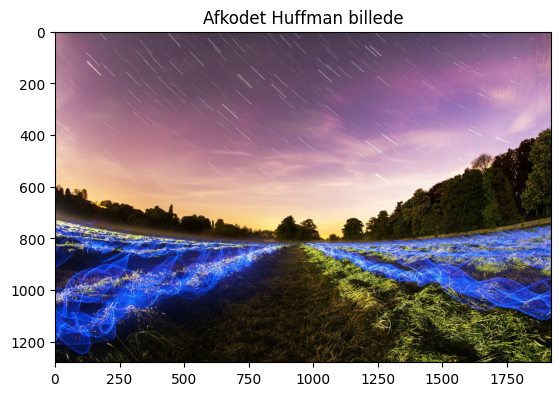

Gennemsnitlig kodelængde per pixel: 7.88 bits
Entropi: 7.85 bits
MSE: 0.00
PSNR: inf dB


In [3]:
image = iio.imread('sample.bmp')
entropy_mountain = Entropy(image)
print(f'Nedre grænse for gennemsnitlig kodelængde per pixel: {entropy_mountain:.2f} bits')

encoded_image, huffman_codes = huffman_encode(image)
decoded_image = huffman_decode(encoded_image, huffman_codes, image.shape)
entropy_mountain = Entropy(decoded_image)
plt.imshow(decoded_image)
plt.title('Afkodet Huffman billede')
plt.show()
print(f'Gennemsnitlig kodelængde per pixel: {len(encoded_image) / image.size:.2f} bits')
print(f'Entropi: {entropy_mountain:.2f} bits')
print(f'MSE: {MSE(image, decoded_image):.2f}')
print(f'PSNR: {PSNR(image, decoded_image):.2f} dB')
